In [1]:
import os
import shutil
import unittest
from catvae.trainer import MultVAE, BiomDataModule
from catvae.sim import multinomial_bioms
from biom import Table
from biom.util import biom_open
import numpy as np
from pytorch_lightning import Trainer
import argparse
import seaborn as sns
import torch
torch.__version__

/mnt/home/djin/miniconda3/envs/catvae/lib/python3.9/site-packages/catvae/models/batch_classifier.py:7: UserWarning: q2_sample_classifier not installed.
  warnings.warn('q2_sample_classifier not installed.')


'1.10.2'

In [2]:
np.random.seed(0)
k, D, N = 10, 50, 1000
sims = multinomial_bioms(k=k, D=D, N=N, M=50000, sigma_sq=0.005)
Y = sims['Y']
parts = Y.shape[0] // 10
samp_ids = list(map(str, range(Y.shape[0])))
obs_ids = list(map(str, range(Y.shape[1])))
train = Table(Y[:parts * 8].T, obs_ids, samp_ids[:parts * 8])
test = Table(Y[parts * 8 : parts * 9].T,
             obs_ids, samp_ids[parts * 8 : parts * 9])
valid = Table(Y[parts * 9:].T, obs_ids, samp_ids[parts * 9:])
tree = sims

with biom_open('train.biom', 'w') as f:
    train.to_hdf5(f, 'train')
with biom_open('test.biom', 'w') as f:
    test.to_hdf5(f, 'test')
with biom_open('valid.biom', 'w') as f:
    valid.to_hdf5(f, 'valid')
    
sims['tree'].write('basis.nwk')

'basis.nwk'

In [3]:
output_dir = 'output'
model = MultVAE(n_input=D, n_latent=k,
                n_hidden=k, basis='basis.nwk',
                dropout=0., bias=True, batch_norm=False,
                encoder_depth=1, learning_rate=0.1,
                overdispersion=True,
                scheduler='cosine', transform='pseudocount')
dm = BiomDataModule('train.biom', 'test.biom', 'valid.biom',
                    batch_size=50)

trainer = Trainer(
    max_epochs=100,
    gpus=1, 
    check_val_every_n_epoch=10,
)
trainer.fit(model, dm)

/mnt/home/djin/miniconda3/envs/catvae/lib/python3.9/site-packages/geotorch/so.py:122: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811793227/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1937.)
  q, r = torch.qr(x)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name | Type         | Params
--------------------------------------
0 | vae  | LinearDLRVAE | 1.2 K 
--------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/mnt/home/djin/miniconda3/envs/catvae/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/mnt/home/djin/miniconda3/envs/catvae/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/mnt/home/djin/miniconda3/envs/catvae/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  25%|██▌       | 4/16 [00:00<00:00, 21.91it/s, loss=7.51e+04, v_num=1283331]

/mnt/home/djin/miniconda3/envs/catvae/lib/python3.9/site-packages/pytorch_lightning/loops/optimization/closure.py:35: LightningDeprecationWarning: One of the returned values {'log'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  rank_zero_deprecation(


Epoch 9:  89%|████████▉ | 16/18 [00:00<00:00, 38.18it/s, loss=7.14e+03, v_num=1283331]
Validating: 0it [00:00, ?it/s]
Epoch 19:  89%|████████▉ | 16/18 [00:00<00:00, 38.06it/s, loss=4.58e+03, v_num=1283331]
Validating: 0it [00:00, ?it/s]
Epoch 29:  89%|████████▉ | 16/18 [00:00<00:00, 38.06it/s, loss=1.93e+03, v_num=1283331]
Validating: 0it [00:00, ?it/s]
Epoch 39:  89%|████████▉ | 16/18 [00:00<00:00, 37.91it/s, loss=1.9e+03, v_num=1283331] 
Validating: 0it [00:00, ?it/s]
Epoch 49:  89%|████████▉ | 16/18 [00:00<00:00, 38.00it/s, loss=1.09e+03, v_num=1283331]
Validating: 0it [00:00, ?it/s]
Epoch 59:  89%|████████▉ | 16/18 [00:00<00:00, 37.99it/s, loss=1.2e+03, v_num=1283331] 
Validating: 0it [00:00, ?it/s]
Epoch 69:  89%|████████▉ | 16/18 [00:00<00:00, 37.93it/s, loss=772, v_num=1283331]     
Validating: 0it [00:00, ?it/s]
Epoch 79:  89%|████████▉ | 16/18 [00:00<00:00, 38.00it/s, loss=1.07e+03, v_num=1283331]
Validating: 0it [00:00, ?it/s]
Epoch 89:  89%|████████▉ | 16/18 [00:00<00:00, 38

In [4]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs

In [5]:
trainer.model

MultVAE(
  (vae): LinearDLRVAE(
    (encoder): Encoder(
      (encoder): Linear(in_features=49, out_features=10, bias=True)
    )
    (decoder): ParametrizedLinear(
      in_features=10, out_features=49, bias=True
      (parametrizations): ModuleDict(
        (weight): GrassmannianTall(n=49, k=10, triv=expm)
      )
    )
    (sigma_net): Linear(in_features=11, out_features=10, bias=True)
  )
)

(0.87819667654801, 0.0)


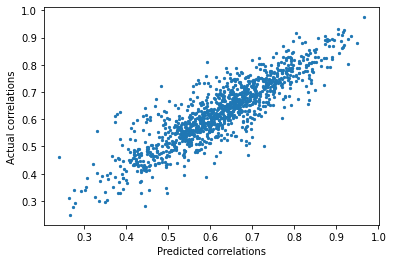

In [6]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

W = model.vae.decoder.weight.detach().cpu().numpy()

d_estW = pdist(W)
simW = sims['W'] / np.sqrt(sims['eigs'])
dW = pdist(simW)

plt.scatter(dW, d_estW, s=5)
#plt.plot(np.linspace(0, 4), np.linspace(0, 4), 'r')
plt.xlabel('Predicted correlations')
plt.ylabel('Actual correlations')

print(pearsonr(dW, d_estW))

In [7]:
sims['sigma']

0.07071067811865475

In [8]:
torch.exp(0.5 * model.vae.log_sigma_sq)

tensor([0.0763, 0.0830, 0.0804, 0.1205, 0.0817, 0.0475, 0.0551, 0.1350, 0.0851,
        0.1178, 0.0965, 0.0492, 0.0560, 0.0721, 0.0748, 0.1299, 0.0651, 0.0969,
        0.0479, 0.0794, 0.0499, 0.0491, 0.0497, 0.0566, 0.0797, 0.0667, 0.0865,
        0.0681, 0.0499, 0.0581, 0.0644, 0.1586, 0.0998, 0.0590, 0.1121, 0.0793,
        0.0598, 0.0797, 0.0669, 0.1162, 0.0383, 0.0803, 0.0884, 0.0501, 0.0546,
        0.0561, 0.0752, 0.0547, 0.0786], grad_fn=<ExpBackward0>)